<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3 - Web APIs & Classification

## Problem Statement

To help counselor, schools and even parents to identify individual who potentially could hold suicidal thoughts. By analysing xisting posts in Reddit, we want to use multiple prediction models for identifying the best model to apply on text written by individual that could predict if this individual holds any suicidal thought, allowing immediate intervention and render support to these group of individuals.

Beside aiming for accuracy of our prediction, we also want to target at the individual who falls under the depresssion category but somehow our prediction shows that this individal is in the suicidual category.

Using Natural Language Processing, success is evaluated by the model has the highest score that combine both accuracy and recall.

## Executive Summary

Using Reddit's API, we will be scraping through the subreddits of 2 posts namely Depression and SuicideWatch.

After examining the scrapped data, we see that the posts itself and the title both hold meaningful words for our analysis. So, we combine these 2 together and apply techniques to split the text into words, return them to their root form and also remove the stop words.
1 interesting outcome was that we ended up having 1 empty post as all words are actually stops words. Since it became an empty post, we decided to drop that post for our analysis.

Once we have cleaned the datasets, we start with putting it into our first modelling which is a simple combination of CountVectorizer and LogisticRegression. Comparing to the baseline accuracy of 51%, this basic model has a better score however it is overfitting.

Using the same model, we added in pipelines and gridsearch to look for the best parameters and see if it will improve the score. The result shows that the variance was greatly reduced however, the accuracy needs to be improved.

We run a function that uses 2 vectorizers (CountVectorizer and TfidVectorizer) with 3 models (LogisticRegression, MultinomialNB and KNeighborsClassifier. That gives a return of 6 results.
As mentioned in the problem statement, we are looking out for individual who fall under the depression category but our prediction shows otherwise. This are the false negatives result we are looking at and thus apart from the accuracy, we will also be focusing on the recall score.


### Contents:
- [Web Scraping](#Web-Scraping)
- [Data Cleaning / EDA / Pre-processing](#Data-Cleaning-/-EDA-/-Pre-processing)

In [1]:
import requests
import time
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import regex as re

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

C:\Users\eukar\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Web Scraping

### Scraping of 1st subreddit from post "Depression"

In [2]:
# 1st subreddit url

url_d = 'https://www.reddit.com/r/depression.json'

In [3]:
# Changing the name of the default user agent to allowing scrapping.

headers = {'User-agent': 'SL Bot 1.0'}
res_d = requests.get(url_d, headers=headers)

In [4]:
# Checking the status code before proceeding where 200 is good to go.

res_d.status_code

200

In [5]:
# naming the scrapped dictionary as depress_dict

depress_dict = res_d.json()

In [6]:
# Checking out the contents and different keys available in depress_dict. 

print(depress_dict.keys())
print(depress_dict['kind'])
print(depress_dict['data'])

dict_keys(['kind', 'data'])
Listing
{'modhash': '', 'dist': 27, 'children': [{'kind': 't3', 'data': {'approved_at_utc': None, 'subreddit': 'depression', 'selftext': 'We understand that most people who reply immediately to an OP with an invitation to talk privately  mean only to help, but this type of response usually leads to either disappointment or disaster.  it usually works out quite differently here than when you say "PM me anytime" in a casual social context.  \n\nWe have huge admiration and appreciation for the goodwill and good citizenship of so many of you who support others here and flag inappropriate content - even more so because we know that so many of you are struggling yourselves.  We\'re hard at work behind the scenes on more information and resources to make it easier to give and get quality help here - this is just a small start.  \n\nOur new wiki page explains in detail why it\'s much better to respond in public comments, at least until you\'ve gotten to know someone

In [7]:
# Further checking out the available keys in depress_dict['data']

depress_dict['data'].keys()

dict_keys(['modhash', 'dist', 'children', 'after', 'before'])

In [8]:
# Also checking out the number of posts for each scrap

len(depress_dict['data']['children'])

27

In [9]:
# Moving on, we are interested with the information in 'children' and 'after'.
# Checking out the various keys in 'children'.

depress_dict['data']['children'][0]['data']['subreddit']

'depression'

In [10]:
# Checking out the various keys in 'children'.

depress_dict['data']['children'][0]['data']['title']

'Our most-broken and least-understood rules is "helpers may not invite private contact as a first resort", so we\'ve made a new wiki to explain it'

In [11]:
# Checking out the various keys in 'children'.

depress_dict['data']['children'][0]['data']['selftext']

'We understand that most people who reply immediately to an OP with an invitation to talk privately  mean only to help, but this type of response usually leads to either disappointment or disaster.  it usually works out quite differently here than when you say "PM me anytime" in a casual social context.  \n\nWe have huge admiration and appreciation for the goodwill and good citizenship of so many of you who support others here and flag inappropriate content - even more so because we know that so many of you are struggling yourselves.  We\'re hard at work behind the scenes on more information and resources to make it easier to give and get quality help here - this is just a small start.  \n\nOur new wiki page explains in detail why it\'s much better to respond in public comments, at least until you\'ve gotten to know someone.  It will be maintained at /r/depression/wiki/private_contact, and the full text of the current version is below.\n\n*****\n\n###Summary###\n\n**Anyone who, while a

In [12]:
# Further extract contents from 'children' only and named it as posts

posts = [p['data'] for p in depress_dict['data']['children']]

In [13]:
# Next, we will check out the 'name' of 'children'.

pd.DataFrame(posts)['name']

0     t3_doqwow
1     t3_exo6f1
2     t3_fhhmja
3     t3_fhj3wq
4     t3_fhfs9q
5     t3_fhj049
6     t3_fh565g
7     t3_fh9m9a
8     t3_fhh3ze
9     t3_fhc71i
10    t3_fhg1nl
11    t3_fhn2ig
12    t3_fhh3jj
13    t3_fhmg13
14    t3_fhgqz5
15    t3_fhfvfg
16    t3_fhgkwv
17    t3_fhis1h
18    t3_fhn1e7
19    t3_fhlvle
20    t3_fhgym2
21    t3_fhhxzc
22    t3_fhklh9
23    t3_fhj1u9
24    t3_fhncl7
25    t3_fhl0tb
26    t3_fhor29
Name: name, dtype: object

In [14]:
# And getting the 'name' of the last post.

depress_dict['data']['after']

't3_fhor29'

In [15]:
# combining the 'name' of the last post with the url to form a new url that gives us the next 27 posts.

url_d + '?after=' + depress_dict['data']['after']

'https://www.reddit.com/r/depression.json?after=t3_fhor29'

In [16]:
# create a function for looping through the posts, 27 posts at a time.

posts_d = []
after = None

for a in range(60):
    if after == None:
        current_url_d = url_d
    else:
        current_url_d = url_d + '?after=' + after
    print(current_url_d)
    res_d = requests.get(current_url_d, headers=headers)
    
    if res_d.status_code != 200:
        print('Status error', res_d.status_code)
        break
    
    current_dict_d = res_d.json()
    current_posts_d = [p['data'] for p in current_dict_d['data']['children']]
    posts_d.extend(current_posts_d)
    after = current_dict_d['data']['after']
    
    # generate a random sleep duration to look more 'natural'
    sleep_duration = random.randint(1,3)
    print(sleep_duration)
    time.sleep(sleep_duration)

https://www.reddit.com/r/depression.json
2
https://www.reddit.com/r/depression.json?after=t3_fhor29
2
https://www.reddit.com/r/depression.json?after=t3_fhmd7v
3
https://www.reddit.com/r/depression.json?after=t3_fhnylh
2
https://www.reddit.com/r/depression.json?after=t3_fhgxlg
1
https://www.reddit.com/r/depression.json?after=t3_fho9f8
2
https://www.reddit.com/r/depression.json?after=t3_fhmv6g
2
https://www.reddit.com/r/depression.json?after=t3_fhfy2n
2
https://www.reddit.com/r/depression.json?after=t3_fhk9r1
3
https://www.reddit.com/r/depression.json?after=t3_fhakh2
2
https://www.reddit.com/r/depression.json?after=t3_fhas1y
3
https://www.reddit.com/r/depression.json?after=t3_fhdgem
2
https://www.reddit.com/r/depression.json?after=t3_fh8s7x
3
https://www.reddit.com/r/depression.json?after=t3_fhdbsc
3
https://www.reddit.com/r/depression.json?after=t3_fhelmp
2
https://www.reddit.com/r/depression.json?after=t3_fhbxcc
2
https://www.reddit.com/r/depression.json?after=t3_fh9fvr
2
https://www.r

In [17]:
# checking out the total number of posts scrapped

len(posts_d)

1499

In [18]:
# checking out the number of unique posts

len(set([p['name'] for p in posts_d]))

948

In [19]:
# Now we want to convert all the posts into a Dataframe, checking out the shape and also the dataframe.

depress_df = pd.DataFrame(posts_d)
print(depress_df.shape)
depress_df.head(3)

(1499, 99)


,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video
0,None,depression,We understand that most people who reply immed...,t2_1t70,False,None,0,False,Our most-broken and least-understood rules is ...,[],...,None,/r/depression/comments/doqwow/our_mostbroken_a...,no_ads,True,https://www.reddit.com/r/depression/comments/d...,614134,1.572361e+09,0,None,False
1,None,depression,Welcome to /r/depression's check-in post - a p...,t2_64qjj,False,None,0,False,Regular Check-In Post,[],...,None,/r/depression/comments/exo6f1/regular_checkin_...,no_ads,True,https://www.reddit.com/r/depression/comments/e...,614134,1.580649e+09,0,None,False
2,None,depression,"Don't get me wrong, I've suffered from severe ...",t2_2uk6lhr0,False,None,0,False,Crippling depression and mental health does no...,[],...,None,/r/depression/comments/fhhmja/crippling_depres...,no_ads,False,https://www.reddit.com/r/depression/comments/f...,614134,1.584025e+09,0,None,False


In [20]:
# create a new column to merge selftext and title columns to combine all the text

depress_df['selftext_title'] = depress_df['selftext'] + depress_df['title']

In [21]:
# dropping the duplicate posts so as to work on unique posts only

depress_df.drop_duplicates(subset='selftext_title', keep='first', inplace=True)

In [22]:
# finally, check out the new dataframe and shape

print(depress_df.shape)
depress_df.head(3)

(945, 100)


,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,selftext_title
0,None,depression,We understand that most people who reply immed...,t2_1t70,False,None,0,False,Our most-broken and least-understood rules is ...,[],...,/r/depression/comments/doqwow/our_mostbroken_a...,no_ads,True,https://www.reddit.com/r/depression/comments/d...,614134,1.572361e+09,0,None,False,We understand that most people who reply immed...
1,None,depression,Welcome to /r/depression's check-in post - a p...,t2_64qjj,False,None,0,False,Regular Check-In Post,[],...,/r/depression/comments/exo6f1/regular_checkin_...,no_ads,True,https://www.reddit.com/r/depression/comments/e...,614134,1.580649e+09,0,None,False,Welcome to /r/depression's check-in post - a p...
2,None,depression,"Don't get me wrong, I've suffered from severe ...",t2_2uk6lhr0,False,None,0,False,Crippling depression and mental health does no...,[],...,/r/depression/comments/fhhmja/crippling_depres...,no_ads,False,https://www.reddit.com/r/depression/comments/f...,614134,1.584025e+09,0,None,False,"Don't get me wrong, I've suffered from severe ..."


### Scraping of 2nd subreddit from post "SuicideWatch"

In [23]:
# 2nd subreddit url

url_s = 'https://www.reddit.com/r/SuicideWatch.json'

In [24]:
# Checking the status code before proceeding where 200 is good to go.

res_s = requests.get(url_s, headers=headers)
res_s.status_code

200

In [25]:
# naming the scrapped dictionary as suicide_dict

suicide_dict = res_s.json()

In [26]:
# Checking out the contents and different keys available in suicide_dict. 

print(suicide_dict.keys())
print(suicide_dict['kind'])
print(suicide_dict['data'])

dict_keys(['kind', 'data'])
Listing
{'modhash': '', 'dist': 27, 'children': [{'kind': 't3', 'data': {'approved_at_utc': None, 'subreddit': 'SuicideWatch', 'selftext': 'We\'ve been seeing a worrying increase in pro-suicide content showing up here and, and also going unreported. This undermines our purpose here, so we wanted to highlight and clarify our guidelines about both direct and indirect incitement of suicide.  \n\nWe\'ve created a wiki that covers these issues.  We hope this will be helpful to anyone who\'s wondering whether something\'s okay here and which responses to report.  It explains in detail why *any* validation of suicidal intent, even an "innocent" message like "if you\'re 100% committed, I\'ll just wish you peace" is likely to increase people\'s pain, and why it\'s important to report even subtle pro-suicide comments. The full text of the wiki\'s current version is below, and it is maintained at [/r/SuicideWatch/wiki/incitement](http://www.reddit.com/r/SuicideWatch/wi

In [27]:
# Further checking out the available keys in suicide_dict['data']

suicide_dict['data'].keys()

dict_keys(['modhash', 'dist', 'children', 'after', 'before'])

In [28]:
# Also checking out the number of posts for each scrap

len(suicide_dict['data']['children'])

27

In [29]:
# Moving on, we are interested with the information in 'children' and 'after'.
# Checking out the various keys in 'children'.

suicide_dict['data']['children'][0]['data']['subreddit']

'SuicideWatch'

In [30]:
# Checking out the various keys in 'children'.

suicide_dict['data']['children'][0]['data']['title']

'New wiki on how to avoid accidentally encouraging suicide, and how to spot covert incitement'

In [31]:
# Checking out the various keys in 'children'.

suicide_dict['data']['children'][0]['data']['selftext']

'We\'ve been seeing a worrying increase in pro-suicide content showing up here and, and also going unreported. This undermines our purpose here, so we wanted to highlight and clarify our guidelines about both direct and indirect incitement of suicide.  \n\nWe\'ve created a wiki that covers these issues.  We hope this will be helpful to anyone who\'s wondering whether something\'s okay here and which responses to report.  It explains in detail why *any* validation of suicidal intent, even an "innocent" message like "if you\'re 100% committed, I\'ll just wish you peace" is likely to increase people\'s pain, and why it\'s important to report even subtle pro-suicide comments. The full text of the wiki\'s current version is below, and it is maintained at [/r/SuicideWatch/wiki/incitement](http://www.reddit.com/r/SuicideWatch/wiki/incitement). \n\nWe deeply appreciate everyone who gives responsive, empathetic, non-judgemental support to our OPs, and we particularly thank everyone who\'s alrea

In [32]:
# Further extract contents from 'children' only and named it as posts

posts = [p['data'] for p in suicide_dict['data']['children']]

In [33]:
# Next, we will check out the 'name' of 'children'.

pd.DataFrame(posts)['name']

0     t3_cz6nfd
1     t3_d2370x
2     t3_fhi2kk
3     t3_fhepsu
4     t3_fhcy8f
5     t3_fhmay8
6     t3_fhnpf5
7     t3_fhi35s
8     t3_fho61y
9     t3_fhl0hm
10    t3_fhiwxu
11    t3_fhftcw
12    t3_fhnr98
13    t3_fhnqzt
14    t3_fhmeka
15    t3_fhna04
16    t3_fhm255
17    t3_fh0abe
18    t3_fhohi3
19    t3_fhocdg
20    t3_fho5w9
21    t3_fhmhf0
22    t3_fhnyut
23    t3_fhfqos
24    t3_fhjcct
25    t3_fhmc3h
26    t3_fhm7cn
Name: name, dtype: object

In [34]:
# And getting the 'name' of the last post.

suicide_dict['data']['after']

't3_fhm7cn'

In [35]:
# combining the 'name' of the last post with the url to form a new url that gives us the next 27 posts.

url_s + '?after=' + suicide_dict['data']['after']

'https://www.reddit.com/r/SuicideWatch.json?after=t3_fhm7cn'

In [36]:
# create a function for looping through the posts, 27 posts at a time.

posts_s = []
after = None

for a in range(60):
    if after == None:
        current_url_s = url_s
    else:
        current_url_s = url_s + '?after=' + after
    print(current_url_s)
    res_s = requests.get(current_url_s, headers=headers)
    
    if res_s.status_code != 200:
        print('Status error', res_s.status_code)
        break
    
    current_dict_s = res_s.json()
    current_posts_s = [p['data'] for p in current_dict_s['data']['children']]
    posts_s.extend(current_posts_s)
    after = current_dict_s['data']['after']
    
    # generate a random sleep duration to look more 'natural'
    sleep_duration = random.randint(1,3)
    print(sleep_duration)
    time.sleep(sleep_duration)

https://www.reddit.com/r/SuicideWatch.json
3
https://www.reddit.com/r/SuicideWatch.json?after=t3_fhm7cn
1
https://www.reddit.com/r/SuicideWatch.json?after=t3_fhl0zw
3
https://www.reddit.com/r/SuicideWatch.json?after=t3_fhd60l
1
https://www.reddit.com/r/SuicideWatch.json?after=t3_fhd62m
1
https://www.reddit.com/r/SuicideWatch.json?after=t3_fhcpoq
1
https://www.reddit.com/r/SuicideWatch.json?after=t3_fhdif2
1
https://www.reddit.com/r/SuicideWatch.json?after=t3_fh11z5
3
https://www.reddit.com/r/SuicideWatch.json?after=t3_fh7yel
2
https://www.reddit.com/r/SuicideWatch.json?after=t3_fhbe9b
1
https://www.reddit.com/r/SuicideWatch.json?after=t3_fh7gw0
3
https://www.reddit.com/r/SuicideWatch.json?after=t3_fgx5ie
3
https://www.reddit.com/r/SuicideWatch.json?after=t3_fh87op
2
https://www.reddit.com/r/SuicideWatch.json?after=t3_fgwcrs
2
https://www.reddit.com/r/SuicideWatch.json?after=t3_fh0igc
1
https://www.reddit.com/r/SuicideWatch.json?after=t3_fh4xqv
2
https://www.reddit.com/r/SuicideWatch.js

In [37]:
# checking out the total number of posts scrapped

len(posts_s)

1488

In [38]:
# checking out the number of unique posts

len(set([p['name'] for p in posts_s]))

986

In [39]:
# Now we want to convert all the posts into a Dataframe, checking out the shape and also the dataframe.

suicide_df = pd.DataFrame(posts_s)
print(suicide_df.shape)
suicide_df.head(3)

(1488, 101)


,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,author_cakeday,link_flair_template_id
0,None,SuicideWatch,We've been seeing a worrying increase in pro-s...,t2_1t70,False,None,1,False,New wiki on how to avoid accidentally encourag...,[],...,no_ads,True,https://www.reddit.com/r/SuicideWatch/comments...,189721,1.567526e+09,0,None,False,NaN,NaN
1,None,SuicideWatch,"If you want to recognise an occasion, please d...",t2_1t70,False,None,0,False,Reminder: Absolutely no activism of any kind i...,[],...,no_ads,True,https://www.reddit.com/r/SuicideWatch/comments...,189721,1.568093e+09,0,None,False,NaN,NaN
2,None,SuicideWatch,my boyfriend shot himself two weeks ago in fro...,t2_9f9hc,False,None,0,False,boyfriend committed suicide in front of me,[],...,no_ads,False,https://www.reddit.com/r/SuicideWatch/comments...,189721,1.584027e+09,0,None,False,NaN,NaN


In [40]:
# create a new column to merge selftext and title columns to combine all the text

suicide_df['selftext_title'] = suicide_df['selftext'] + suicide_df['title']

In [41]:
# dropping the duplicate posts so as to work on unique posts only

suicide_df.drop_duplicates(subset='selftext_title', keep='first', inplace=True)

In [42]:
# finally, check out the new dataframe and shape

print(suicide_df.shape)
suicide_df.head(3)

(985, 102)


,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,author_cakeday,link_flair_template_id,selftext_title
0,None,SuicideWatch,We've been seeing a worrying increase in pro-s...,t2_1t70,False,None,1,False,New wiki on how to avoid accidentally encourag...,[],...,True,https://www.reddit.com/r/SuicideWatch/comments...,189721,1.567526e+09,0,None,False,NaN,NaN,We've been seeing a worrying increase in pro-s...
1,None,SuicideWatch,"If you want to recognise an occasion, please d...",t2_1t70,False,None,0,False,Reminder: Absolutely no activism of any kind i...,[],...,True,https://www.reddit.com/r/SuicideWatch/comments...,189721,1.568093e+09,0,None,False,NaN,NaN,"If you want to recognise an occasion, please d..."
2,None,SuicideWatch,my boyfriend shot himself two weeks ago in fro...,t2_9f9hc,False,None,0,False,boyfriend committed suicide in front of me,[],...,False,https://www.reddit.com/r/SuicideWatch/comments...,189721,1.584027e+09,0,None,False,NaN,NaN,my boyfriend shot himself two weeks ago in fro...


Next, we will save a copy of the dataframe to csv.
Commenting out the below code so that it will not overwrite the saved file for subsequent reference and to save time on waiting for the scraped data.

In [43]:
# depress_df.to_csv('datasets\depress.csv', index=False)

In [44]:
# suicide_df.to_csv('datasets\suicide.csv', index=False)

# Data Cleaning / EDA / Pre-processing

### Import both datasets.

In [45]:
depress = pd.read_csv('.\datasets\depress.csv')
suicide = pd.read_csv('.\datasets\suicide.csv')

In [46]:
# Checking out the shapes of both datasets.

print(depress.shape)
print(suicide.shape)

(946, 101)
(984, 101)


Recalling that our target is the column 'subreddit'. We will then need to create a target vector in our datasets that indicate binary values for either depress or suicide.

In [47]:
# Create the target variable.

depress['is_suicide'] = 0
suicide['is_suicide'] = 1

In [48]:
# As we only need data from selftext_title as our feature and is_suicide as the dependent variable, we will proceed to drop all other columns

depress = depress[['selftext_title', 'is_suicide']]
suicide = suicide[['selftext_title', 'is_suicide']]

In [49]:
# Inspect data from selftext_title (depress dataset)
# select 3rd post as the 1st 2 are merely guidelines and welcome to subreddit.

depress.selftext_title[3]

'Hey there, just want to share some recent triumphs I had.\nI haven’t had thoughts of killing myself, of imag9ning all the ways to kill myself since the beginning of January! And it’s March now!!\nThis is the longest streak I have ever gone in my life. \nI sincerely, sincerely, with all my hearts wish the best, the BEST for all the redditors in this sub. All of my hearts. \nI cannot stress this enough. I truly truly wish everyone can go their days, even just ONE day, without thinking of suicide, feeling a little bit of relief for even just a day.\nI may not know you in real life, but I truly see you as my friend, and I wish you have a joyful life.\n\nLove.I haven’t had suicidal thoughts for over two months'

In [50]:
# Inspect the 1st data from selftext_title (suicide dataset)
# select 3rd post as the 1st 2 are merely guidelines and welcome to subreddit.

suicide.selftext_title[3]

"Dear friends and family,  \n\n\nI've lost my long battle with my thoughts. I'm taking my own life.  \n\n\nWhat I am going to do is inexcusable and I know I'm going to put a lot of people through a lot of pain. I can't pretend that I won't be missed, I am making my decision with that very much at the forefront of my mind. My suicide is selfish to be sure. But I can't keep living just because of what is essentially a feeling of guilt. I hope you can find it in your heart to forgive me. I am deeply sorry.  \n\n\nI also want you to know that I don't blame anybody. Especially not my parents. I am going into the grave at peace in this regard. You shouldn't blame yourself either. Anybody who knows me well, knows that I've had suicidal tendencies for a long time. I'm sick of making what are basically just thinly veiled threats. It's time for me to take action, and take control.  \n\n\nI blame myself for everything. Every day I am doing new things that I'm going to feel insecure about later. A

In [51]:
# for reference on below steps regarding empty string after removing stopwords. 

suicide.selftext_title[207]

'What should I do?'

### Data Dictionary

In [52]:
%%html
<style>
table {float:left}
</style>

| Features       	| Descriptions                                                                	|
|:----------------	|:-----------------------------------------------------------------------------	|
| selftext       	| Posts written by subreddits communities                                     	|
| title          	| Title/header of the posts                                                   	|
| selftext_title 	| Combination of both the posts and title                                     	|
| is_suicide     	| posts from SuicideWatch subreddits = 1 posts from Depression subreddits = 0 	|

### Next, I will clean the data in the selftext_title Series to create a bag of words

In [53]:
def text_to_words(series):
    new_list = []
    lemmatizer = WordNetLemmatizer()
    
    for i in range(len(series)):
    
        letters_only = re.sub("[^a-zA-Z]", " ", series[i]) # remove non-letters
        words = letters_only.lower().split() # convert to lower case, split into individual words
        stops = set(stopwords.words('english')) # convert stop words to a set
        meaningful_words = [w for w in words if not w in stops] # remove stop words
        meaningful_words_lem = [lemmatizer.lemmatize(i) for i in meaningful_words]
        
        string_clean = " ".join(meaningful_words_lem)
        new_list.append(string_clean)
    return new_list

In [54]:
# Renaming the clean text to the original Series and conduct a check.

depress['selftext_title'] = text_to_words(depress['selftext_title'])
depress.head()

,selftext_title,is_suicide
0,understand people reply immediately op invitat...,0
1,welcome r depression check post place take mom...,0
2,worst time dealing pain know new pain quite li...,0
3,hey want share recent triumph thought killing ...,0
4,want say fuck life fuck life,0


In [55]:
# Doing the same as above for suicide datset.

suicide['selftext_title'] = text_to_words(suicide['selftext_title'])
suicide.head()

,selftext_title,is_suicide
0,seeing worrying increase pro suicide content s...,1
1,want recognise occasion please offering extra ...,1
2,please get one comment upvote wanna feel alone...,1
3,dear friend family lost long battle thought ta...,1
4,first time decade getting help needed never la...,1


Creating a wordcloud for both datasets

In [56]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords = stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

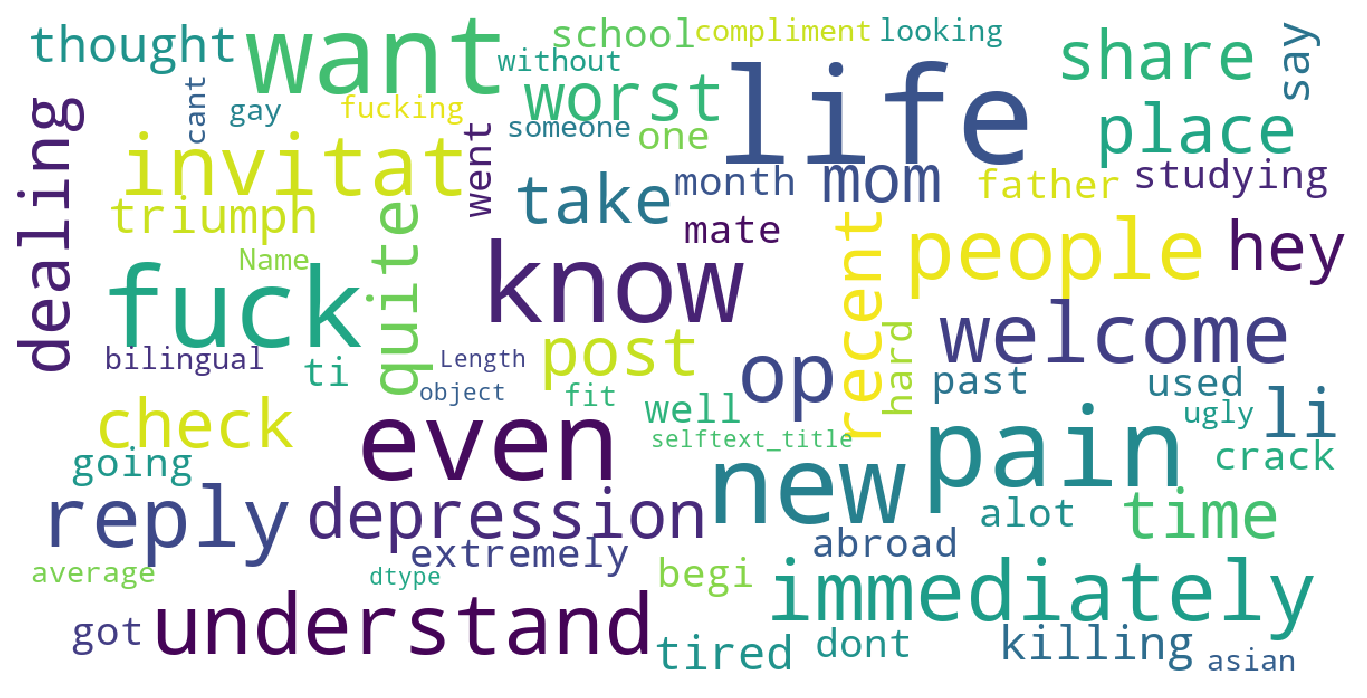

In [57]:
show_wordcloud(depress['selftext_title'])

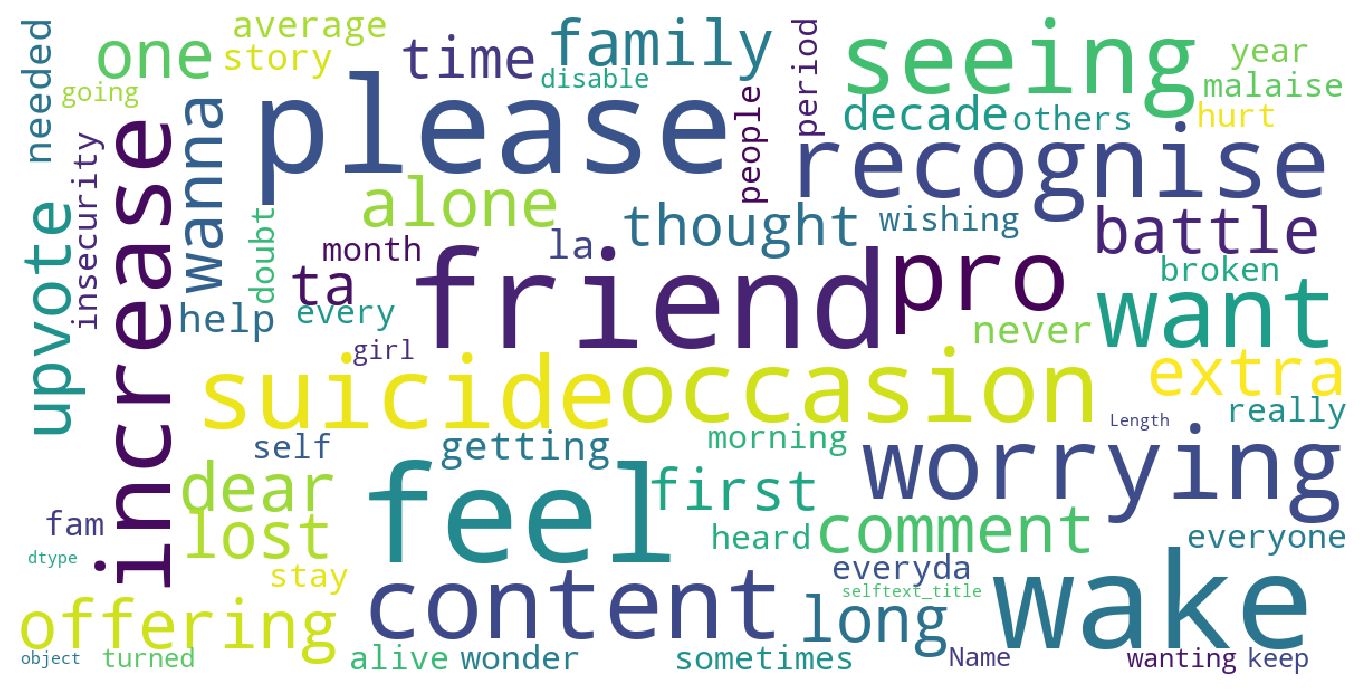

In [58]:
show_wordcloud(suicide['selftext_title'])

Based on the wordcloud, we are roughly tell which are the more prominate words that appear for each datasets.\
However, we will want to have a clearer understanding the fequency and the weight of these words.\
We will use both CountVectorizer and TfidVectorizer from scikit-learn to create features from the selftext_title.

In [59]:
# Instantiate CountVectorizer

vectorizer = CountVectorizer(stop_words = 'english')

In [60]:
# Fit and transform depress dataset

depress_cvec = vectorizer.fit_transform(depress['selftext_title'])

In [61]:
# Convert the total word count into DataFrame

depress_cvec_df = pd.DataFrame(depress_cvec.todense(), columns=vectorizer.get_feature_names())
depress_cvec_df.head()

,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,abandon,abandoned,abandoning,abandonment,abdominal,abilites,ability,abit,able,...,youtubers,yr,zealous,zero,zi,zip,zoloft,zombie,zone,zoned
0,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
# find out how many times each word appear in selftext_title by creating a 'Total' row at the end of the dataframe:

depress_cvec_df.loc['Total',:]= depress_cvec_df.sum(axis=0)
depress_cvec_df.loc['Total',:].sort_values(ascending=False)

feel                                                                                  1328.0
like                                                                                  1305.0
know                                                                                   846.0
want                                                                                   824.0
life                                                                                   777.0
                                                                                       ...  
meditate                                                                                 1.0
meditating                                                                               1.0
megalomaniac                                                                             1.0
meh                                                                                      1.0
aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa

In [63]:
# Convert it to a DataFrame

depress_cvec_df_count = pd.DataFrame(depress_cvec_df.loc['Total',:].sort_values(ascending=False))
depress_cvec_df_count.head(30)

,Total
feel,1328.0
like,1305.0
know,846.0
want,824.0
life,777.0
time,699.0
friend,587.0
people,578.0
thing,535.0
really,525.0


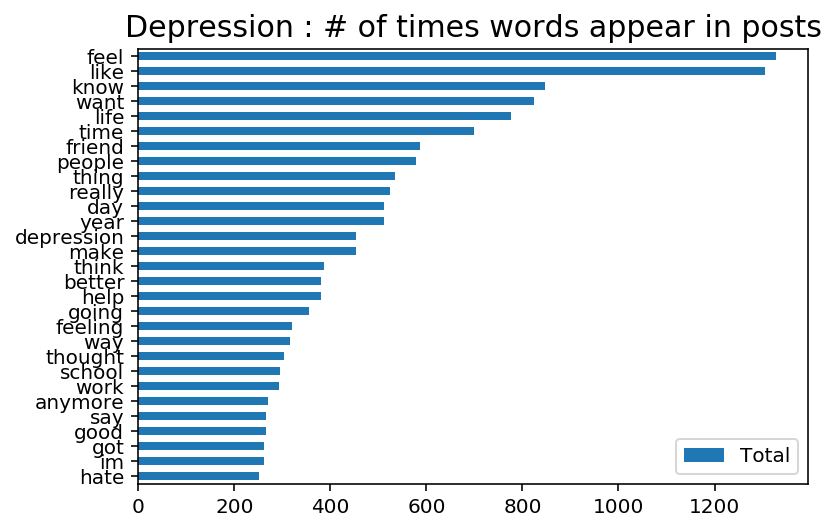

In [64]:
# plotting the above Dataframe to a bar chart

depress_cvec_df_count[depress_cvec_df_count.Total > 250].plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Depression : # of times words appear in posts', fontsize=15);

In [65]:
# Let's make the above the same for suicide dataset
# Fit and transform suicide dataset

suicide_cvec = vectorizer.fit_transform(suicide['selftext_title'])

In [66]:
# Convert the total word count into DataFrame

suicide_cvec_df = pd.DataFrame(suicide_cvec.todense(), columns=vectorizer.get_feature_names())
suicide_cvec_df.head()

,aaaaallllll,ab,abandon,abandoned,abandonment,abandonned,abdomen,ability,able,abolition,...,youthe,youtube,yr,zap,zero,zip,zit,zombie,zone,zopiclone
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
# find out how many times each word appear in selftext_title by creating a 'Total' row at the end of the dataframe:

suicide_cvec_df.loc['Total',:]= suicide_cvec_df.sum(axis=0)
suicide_cvec_df.loc['Total',:].sort_values(ascending=False)

want           1027.0
like            943.0
feel            884.0
life            828.0
know            781.0
                ...  
moderator         1.0
mode              1.0
mock              1.0
mistreating       1.0
aaaaallllll       1.0
Name: Total, Length: 6925, dtype: float64

In [68]:
# Convert it to a DataFrame

suicide_cvec_df_count = pd.DataFrame(suicide_cvec_df.loc['Total',:].sort_values(ascending=False))
suicide_cvec_df_count.head(30)

,Total
want,1027.0
like,943.0
feel,884.0
life,828.0
know,781.0
time,541.0
year,539.0
people,515.0
friend,497.0
think,467.0


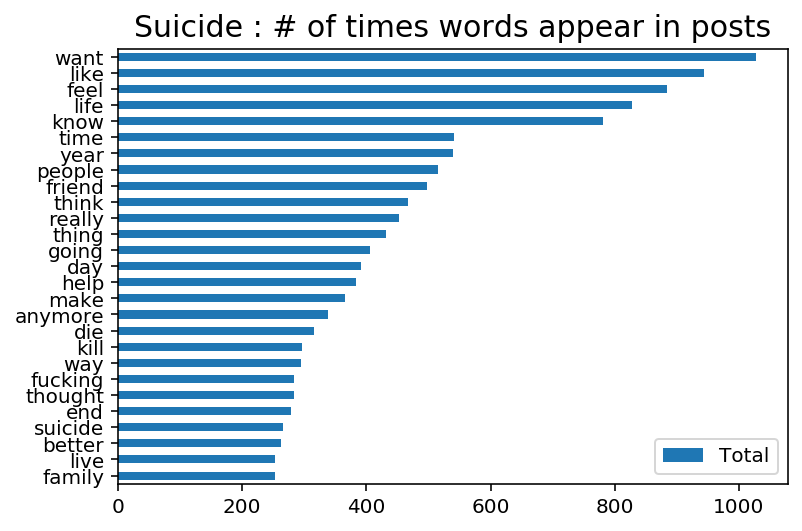

In [69]:
# plotting the above Dataframe to a bar chart

suicide_cvec_df_count[suicide_cvec_df_count.Total > 250].plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Suicide : # of times words appear in posts', fontsize=15);

Now, checking out using TfidVectorizer

In [70]:
# Instantiate TfidVectorizer

tfvec = TfidfVectorizer(stop_words = 'english')

In [71]:
# Fit and transform suicide dataset

depress_tfvec = tfvec.fit_transform(depress['selftext_title'])

In [72]:
# Convert into DataFrame

depress_tfvec_df = pd.DataFrame(depress_tfvec.todense(), columns=tfvec.get_feature_names())
depress_tfvec_df.head()

,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,abandon,abandoned,abandoning,abandonment,abdominal,abilites,ability,abit,able,...,youtubers,yr,zealous,zero,zi,zip,zoloft,zombie,zone,zoned
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033274,0.0,0.022121,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
# find out what is the weight of each word that appear in selftext_title by creating a 'Total' row at the end of the dataframe:

depress_tfvec_df.loc['Total',:]= depress_tfvec_df.sum(axis=0)
depress_tfvec_df.loc['Total',:].sort_values(ascending=False)

feel           52.021537
like           46.089282
want           36.526849
know           34.847843
life           33.136313
                 ...    
suspense        0.023011
infatuation     0.023011
ambitious       0.023011
vermont         0.023011
fondle          0.023011
Name: Total, Length: 7388, dtype: float64

In [74]:
# Convert it to a DataFrame

depress_tfvec_df_count = pd.DataFrame(depress_tfvec_df.loc['Total',:].sort_values(ascending=False))
depress_tfvec_df_count.head(30)

,Total
feel,52.021537
like,46.089282
want,36.526849
know,34.847843
life,33.136313
friend,28.870366
time,27.953995
people,27.101089
really,26.238420
depression,25.117195


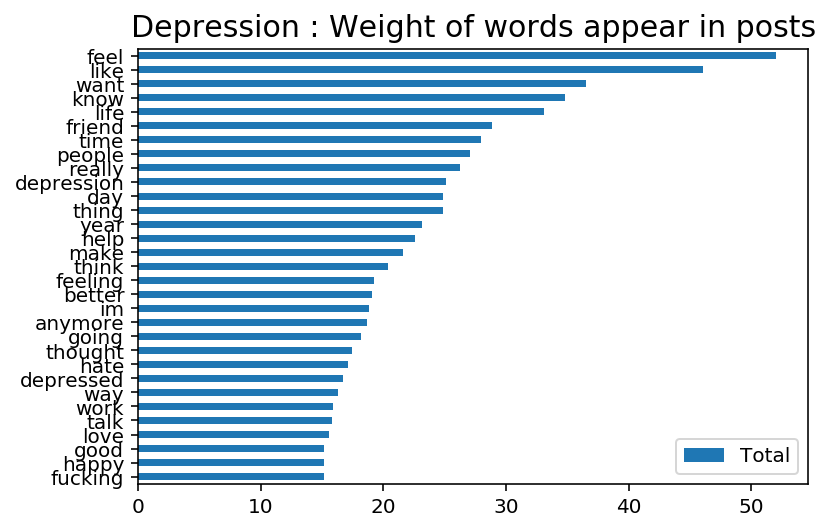

In [75]:
# plotting the above Dataframe to a bar chart

depress_tfvec_df_count[depress_tfvec_df_count.Total > 15].plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Depression : Weight of words appear in posts', fontsize=15);

In [76]:
# Let's make the above the same for suicide dataset
# Fit and transform suicide dataset

suicide_tfvec = tfvec.fit_transform(suicide['selftext_title'])

In [77]:
# Convert into DataFrame

suicide_tfvec_df = pd.DataFrame(suicide_tfvec.todense(), columns=tfvec.get_feature_names())
suicide_tfvec_df.head()

,aaaaallllll,ab,abandon,abandoned,abandonment,abandonned,abdomen,ability,able,abolition,...,youthe,youtube,yr,zap,zero,zip,zit,zombie,zone,zopiclone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012759,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
# find out what is the weight of each word that appear in selftext_title by creating a 'Total' row at the end of the dataframe:

suicide_tfvec_df.loc['Total',:]= suicide_tfvec_df.sum(axis=0)
suicide_tfvec_df.loc['Total',:].sort_values(ascending=False)

want         51.192683
feel         41.574575
like         40.031014
life         38.031777
know         35.788256
               ...    
fasted        0.019978
summarize     0.019978
nourish       0.019978
cupboard      0.019978
bin           0.019978
Name: Total, Length: 6925, dtype: float64

In [79]:
# Convert it to a DataFrame

suicide_tfvec_df_count = pd.DataFrame(depress_tfvec_df.loc['Total',:].sort_values(ascending=False))
suicide_tfvec_df_count.head(30)

,Total
feel,52.021537
like,46.089282
want,36.526849
know,34.847843
life,33.136313
friend,28.870366
time,27.953995
people,27.101089
really,26.238420
depression,25.117195


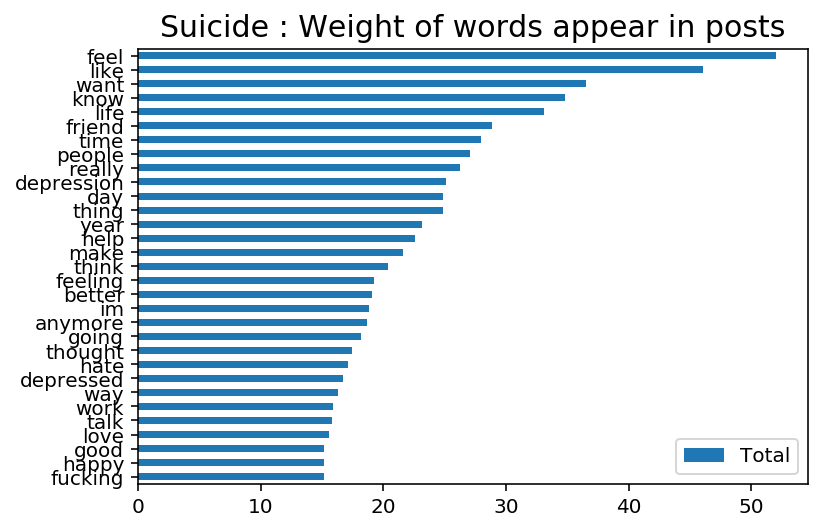

In [80]:
# plotting the above Dataframe to a bar chart

suicide_tfvec_df_count[suicide_tfvec_df_count.Total > 15].plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Suicide : Weight of words appear in posts', fontsize=15);

In [81]:
# Checking out if there's any null post in the dataset

print('Missing data in depress dataset:\n', depress.isnull().sum())
print('Missing data in suicide dataset:\n', suicide.isnull().sum())

Missing data in depress dataset:
 selftext_title    0
is_suicide        0
dtype: int64
Missing data in suicide dataset:
 selftext_title    0
is_suicide        0
dtype: int64


#### It seems that some words are appearing very often and commonly in these 2 posts e.g. feel, like, want, know, life, etc.

Further into the modeling, I realized that I can't proceed with CountVectorizer with an error message\
ValueError: np.nan is an invalid document, expected byte or unicode string.

This error suggest that there is null value so back here to investigate.

In [82]:
#Find index of rows with empty strings for suicide dataset

suicide[suicide.iloc[:,0]==''].index.tolist()

[207]

In [83]:
#Find index of rows with empty strings for depress dataset

depress[depress.iloc[:,0]==''].index.tolist()

[]

In [84]:
# Checking out the shape of suicide dataset

suicide.shape

(984, 2)

In [85]:
# Empty strings identified in suicide dataset. 
# Did a check in the original dataset and realized that this post contains all stop_words
# suicide.selftext_title[207] shows 'What should I do'
# Thus when we use stop_words, it remove all these text leaving behind an empty string.
# In this case, will drop this row.

suicide.drop(index=207,inplace=True)

In [86]:
# Checking out the shape and also empty string after dropping to ensure we have dropped it successfully

print(suicide.shape)
suicide[suicide.iloc[:,0]==''].index.tolist()

(983, 2)


[]

In [87]:
# Saving a copy the cleaning datasets

depress_clean = depress
suicide_clean = suicide

depress_clean.to_csv('datasets\depress_clean.csv', index=False)
suicide_clean.to_csv('datasets\suicide_clean.csv', index=False)